In [1]:
%matplotlib inline

import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

In [2]:
# Configs ----------------------------------------------------------------------

# takes only current needed GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# random numbers
random_seed = 1
rng = np.random.RandomState(random_seed)

In [3]:
# Utils ------------------------------------------------------------------------

def mackey_glass(stime = 30000, dt = 0.05,
        beta = 2., gamma = 1., n = 9.65, tau = 2):
    d = int(tau/dt)    
    x = 3.0*np.ones(2*stime + d)
    for t in range(tau-1, 2*stime):
        x[t+1] = x[t] + dt*(
                beta*x[t-d] / (1.0 + x[t-d]**n)
                - gamma*x[t] )
    return x[2*d: stime + 2*d], d

def mult_sines(stime = 1200):
    res = np.arange(stime)
    res = np.sin(res) + np.sin(0.51*res) \
        + np.sin(0.22*res) \
        + np.sin(0.1002*res) \
        + np.sin(0.05343*res)
    
    res -= res.min() 
    res /= res.max()
    
    return res

def NRMSE(P, Y):
    return tf.sqrt(tf.reduce_mean(tf.squared_difference(P, Y))) / (tf.reduce_max(Y) - tf.reduce_min(Y))
    

In [4]:
# Global variables --------------------------------------------------------------

batches = 1
stime = 700
num_units = 10
num_inputs = 1

# the activation function of the ESN
out_function = lambda x:  math_ops.tanh(x)


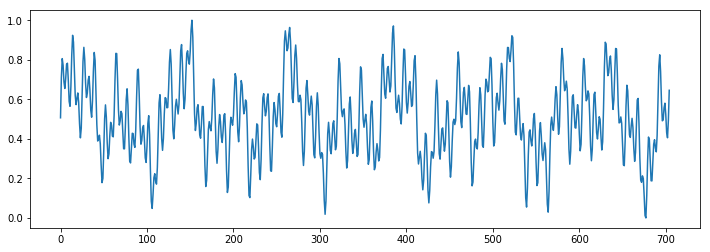

In [5]:
# input -------------------------------------------------------------------------
rnn_inputs = np.zeros((batches, stime, num_inputs), dtype="float32")
wave = mult_sines(stime+5).astype("float32")
rnn_inputs = wave[5:].reshape(1,stime, 1)
rnn_init_state = np.zeros([batches, num_units], dtype="float32")
plt.figure(figsize=(12,4))
wave_line, = plt.plot(wave)

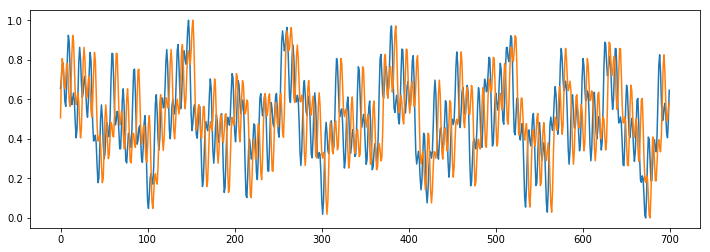

In [6]:
# the output target - mackey-glass ----------------------------------------------
rnn_target = wave[:-5]
rnn_target = rnn_target.reshape(stime, 1).astype("float32")
plt.figure(figsize=(12,4))
inp_line, = plt.plot(rnn_inputs[0,:,:])
targ_line, = plt.plot(rnn_target)


In [7]:
# tensorflow graph -------------------------------------------------------------

tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default() as g:
    
    rng = np.random.RandomState(random_seed)
    lr = 0.01
    
    # Build the graph
    
    inputs = tf.placeholder(tf.float32, [batches, stime, num_inputs])
    target = tf.placeholder(tf.float32, [stime, 1])
    init_state = tf.placeholder(tf.float32, [1, num_units])

    # Init the ESN cell
    print "Making ESN init graph ..."
    cell = EchoStateRNNCell(num_units=num_units, 
                            activation=out_function, 
                            decay=0.1, 
                            alpha=0.5,
                            rng=rng, 
                            optimize=True,
                            optimize_vars=["rho", "decay","alpha", "sw"])
    print "Done"
    
    # cell spreading of activations
    print "Making ESN spreading graph ..."
    states = []
    state = init_state
    for t in range(stime):
        state,_ = cell(inputs=inputs[0,t:(t+1),:], state=state)
        states.append(state)
    outputs = tf.reshape(states, [stime, num_units])   
    print "Done"

    # ridge regression
    print "Making regression graph ..."
    # do the regression on a training subset of the timeseries
    begin =  200
    end = stime
    
    # optimize also lambda
    lmb = tf.get_variable("lmb", initializer=0.1, 
                          dtype=tf.float32, trainable=True)
    
    output_slice = outputs[begin:end,:]

    Wout = tf.matmul( 
            tf.matrix_inverse(tf.matmul(tf.transpose(output_slice), output_slice) +
                lmb*tf.eye(num_units)),
            tf.matmul(tf.transpose(output_slice), target[begin:end,:]) )
    print "Done"

    # readout
    print "Making readout spreading graph ..."
    readouts = tf.matmul(outputs, Wout)
    print "Done"
    
    # train graph
    print "Making training graph ..."    
    # calculate the loss over all the timeseries (escluded the beginning)
    clip_rho = cell.rho.assign(tf.clip_by_value(cell.rho, 0.0, 1.0))
    clip_alpha = cell.alpha.assign(tf.clip_by_value(cell.alpha, 0.0, 1.0))
    clip_decay = cell.decay.assign(tf.clip_by_value(cell.decay, 0.0, 1.0))
    clip_sw = cell.decay.assign(tf.clip_by_value(cell.sw, 0.0001, 0.5))
    clip_lmb = cell.decay.assign(tf.clip_by_value(lmb, 0.0001, 0.5))
    clip = tf.group(clip_rho, clip_alpha, clip_decay,clip_sw, clip_lmb)
    loss = NRMSE(target[begin:end,:], readouts[begin:end,:]) 
    try: # if optimize == True
        optimizer = tf.train.GradientDescentOptimizer(lr)
        train = optimizer.minimize(loss)
    except ValueError: # if optimize == False
        train = tf.get_variable("trial", (), dtype=None)
    print "Done"    

Making ESN init graph ...
Done
Making ESN spreading graph ...
Done
Making regression graph ...
Done
Making readout spreading graph ...
Done
Making training graph ...
Done


In [ ]:
# run session -----------------------------------------------------------------
with graph.as_default() as g:

    trials = 2000
    with tf.Session(config=config) as session:
        session.run(tf.global_variables_initializer())
        losses = np.zeros(trials)
        print "Executing the graph"
        for k in range(trials):
            rho, alpha, decay, sw, U, curr_outputs, curr_readouts,curr_loss,_ = \
                    session.run([cell.rho, cell.alpha, cell.decay, cell.sw,
                                 cell.U, outputs, readouts,
                                 loss, train ], feed_dict={inputs:rnn_inputs,
                                                           target: rnn_target,
                                                           init_state:rnn_init_state})
            session.run(clip)
            if k%20 == 0 or k == trials-1:
                sys.stdout.write("step: {:4d}\t".format(k))
                sys.stdout.write("NRMSE: {:5.3f}\t".format(curr_loss))
                sys.stdout.write("rho: {:5.3f}\t".format(rho))
                sys.stdout.write("alpha: {:5.3f}\t".format(alpha))
                sys.stdout.write("decay: {:5.3f}\t".format(decay))
                sys.stdout.write("sw: {:5.3f}\n".format(decay))

            losses[k] = curr_loss
        print "Done"


In [ ]:
    # plot results ---------------------------------------------------------------
    
    plt.figure(figsize=(10,8))
    plt.subplot(411, aspect="equal")
    eigs = np.linalg.eigvals(U*rho)
    plt.scatter(eigs.real, eigs.imag, s=1)
    plt.xlim([-rho, rho])
    plt.ylim([-rho, rho])
    plt.subplot(412)
    plt.plot(curr_outputs)
    plt.xlim([-10, stime+10])
    plt.subplot(413)
    plt.plot(range(begin,end),rnn_target[begin:end,:], 
            color="green", lw=6)
    plt.plot(rnn_target, color="red")
    plt.plot(curr_readouts, color="blue")
    plt.xlim([-10, stime+10])
    plt.subplot(414)
    plt.plot(losses)
    plt.show()
